In [2]:
from nltk.corpus import semcor
import pandas as pd
import numpy as np
from core.semcor_bert_pipeline import *

We look at types' frequency in SEMCOR and compute their entropy

## Creating a Dataframe of all the tags in SEMCOR

In [3]:
tagged_sents = nltk.corpus.semcor.tagged_sents(tag = 'sem')

In [4]:
sel = SemCorSelector()

In [5]:
tag_freqs = {}
for s in tagged_sents:
    for tok in s:
        if type(tok) == nltk.tree.Tree:
            if tok.label() in tag_freqs.keys():
                tag_freqs[tok.label()] += 1
            else:
                tag_freqs[tok.label()] = 1
    

KeyboardInterrupt: 

In [ ]:
freqs = pd.DataFrame(pd.Series(tag_freqs)).reset_index()
freqs.columns = ['lemma', 'count']
sorted_freqs = freqs.sort_values('count', ascending = False)
words = []
def get_word(lem):
    if type(lem) == nltk.corpus.reader.wordnet.Lemma:
        return lem.name()
    else:
        return lem.split('.')[0]
sorted_freqs['word'] = sorted_freqs['lemma'].apply(get_word)

In [ ]:
decomp_tags = []
for s in tagged_sents:
    for tok in s:
        if type(tok) == nltk.tree.Tree:
            lem = tok.label()
            decomp_tags.append({'lemma': lem, 'word': get_word(lem), 
                                'pos': get_pos(lem), 'sense': get_sense_num(lem)})
            
semcor_tags = pd.DataFrame(decomp_tags)

In [ ]:
semcor_tags.to_csv('../data/semcor_tags.csv', index = False)

## Filtering the Original Dataset

In [5]:
import pandas as pd

In [6]:
semcor_tags = pd.read_csv('../data/semcor_tags.csv')

In [7]:
len(semcor_tags.index) #Number of annotated tokens in SEMCOR

235079

In [8]:
word_freqs = semcor_tags[['word', 'pos']].groupby('word').agg('count').rename({'pos':'freq'}, axis = 1)
above_10 = word_freqs[word_freqs['freq'] > 10]
above_10 #Words with at least 10 instances

,freq
word,
0,23
1,128
10,73
100,38
1000,19
...,...
yield,29
young,103
young_man,14


TODO: this needs to be changed (shouldnt be by word, PoS, and sense number)

In [9]:
freq_tags = semcor_tags[semcor_tags['word'].isin(above_10.index)]
filtered_sense_freqs = freq_tags.groupby(['word', 'pos', 'sense']).agg('count').rename({'lemma': 'freq'},
                                                                axis = 1)
filtered_sense_freqs.sort_values('freq', ascending = False)

Unnamed: 0   freq
word   pos sense                   
be     v   01          11221  11221
person n   01           6696   6696
be     v   02           2996   2996
say    v   01           1939   1939
not    r   01           1703   1703
...                      ...    ...
heavy  s   0;1             1      1
solid  s   09              1      1
           10              1      1
           1;7             1      1
zero   s   03              1      1

[11287 rows x 2 columns]

In [10]:
filtered_sense_freqs = filtered_sense_freqs[filtered_sense_freqs['freq'] >= 10].reset_index()
filtered_sense_freqs = filtered_sense_freqs[['word','pos', 'sense', 'freq']]
filtered_sense_freqs

,word,pos,sense,freq
0,0,n,02,20
1,1,n,01,21
2,1,s,01,107
3,10,s,01,69
4,100,s,01,33
...,...,...,...,...
4090,yesterday,n,01,13
4091,yet,r,01,34
4092,young,a,01,95
4093,young_man,n,01,14


As there are 4,095 words with more than 10 occurrences per sense, we find the entropy of each word/POS pair.

In [11]:
filtered_sense_freqs.sort_values('freq', ascending = False)

,word,pos,sense,freq
427,be,v,01,11221
2651,person,n,01,6696
428,be,v,02,2996
3170,say,v,01,1939
2447,not,r,01,1703
...,...,...,...,...
2578,painful,a,01,10
2541,orchestra,n,01,10
2535,operator,n,02,10
2501,oil,n,01,10


In [12]:
from scipy import stats
import numpy as np

### Computing entropy

In [13]:
entropy_df = []
for w in np.unique(filtered_sense_freqs['word']):
    word_freqs = filtered_sense_freqs[filtered_sense_freqs['word'] == w]
    for p in np.unique(word_freqs['pos']):
        word_pos_freqs = word_freqs[word_freqs['pos'] == p]
        freqs = word_pos_freqs['freq']
        dist = freqs / sum(freqs)
        ent = stats.entropy(freqs.values, base = 2)
        ent_dict = {'word': w, 'pos': p, 'entropy': ent}
        entropy_df.append(ent_dict)

In [14]:
entropy_df = pd.DataFrame(entropy_df).sort_values('entropy', ascending = False)
entropy_df

,word,pos,entropy
2780,take,v,2.815106
2843,thing,n,2.812869
1747,meet,v,2.774648
1606,lead,v,2.684982
1613,leave,v,2.386495
...,...,...,...
1124,feed,n,0.000000
1127,feel_like,v,0.000000
1129,fellow,n,0.000000
1130,female,a,0.000000


In [23]:
entropy_df[entropy_df['word'] == 'put']

,word,pos,entropy
2233,put,v,1.40234


In [60]:
import matplotlib.pyplot as plt

In [36]:
len(entropy_df[entropy_df['entropy'] == 0]) / len(entropy_df) #Percent of types w/zero entropy

0.7937880243355747

In [24]:
np.mean(entropy_df[entropy_df['entropy'] != 0]) #average entropy

entropy    1.061552
dtype: float64

Text(0.5, 0, 'Entropy')

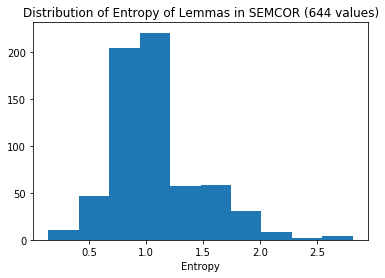

In [61]:
entropy_df = entropy_df[entropy_df['entropy'] != 0]
plt.hist(entropy_df['entropy'])
plt.title("Distribution of Entropy of Lemmas in SEMCOR (644 values)")
plt.xlabel("Entropy")

Merging the frequency & entropy dataframes.

In [62]:
sense_freqs = filtered_sense_freqs.groupby(['word', 'pos']).agg('count')
sense_freqs.drop('sense', axis = 1, inplace = True)
sense_freqs = sense_freqs.reset_index()
sense_totals = filtered_sense_freqs.groupby(['word', 'pos']).agg('sum')
sense_totals = sense_totals.reset_index()
entropy_df = entropy_df.merge(sense_freqs, on = ['word', 'pos']).rename({'freq': 'num_senses'}, axis = 1)
entropy_df = entropy_df.merge(sense_totals, on = ['word', 'pos'])

In [81]:
import nltk
from nltk.corpus import stopwords

In [93]:
entropy_df = entropy_df[~entropy_df['word'].isin(set(stopwords.words('english')))] #Remove stopwords
entropy_df

,word,pos,entropy,num_senses,freq
0,take,v,2.815106,12,675
1,thing,n,2.812869,8,264
2,meet,v,2.774648,9,214
3,lead,v,2.684982,7,170
4,leave,v,2.386495,8,376
...,...,...,...,...,...
637,good,a,0.326969,2,167
640,even,r,0.207177,2,399
641,want,v,0.201026,2,383
642,year,n,0.198416,2,422


Text(0.5, 1.0, 'Entropy vs. Log Frequency for 622 Highest-Entropy Words in SEMCOR')

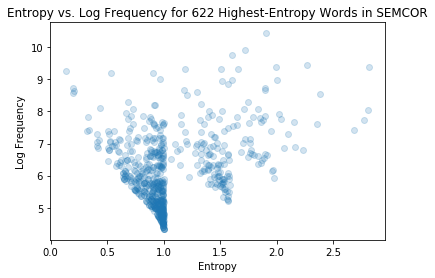

In [97]:
plt.scatter(entropy_df['entropy'], np.log2(entropy_df['freq']), alpha = 0.2)
plt.xlabel("Entropy")
plt.ylabel("Log Frequency")
plt.title("Entropy vs. Log Frequency for 622 Highest-Entropy Words in SEMCOR")

In [99]:
entropy_df.sort_values('entropy', ascending = False)[:10]

,word,pos,entropy,num_senses,freq
0,take,v,2.815106,12,675
1,thing,n,2.812869,8,264
2,meet,v,2.774648,9,214
3,lead,v,2.684982,7,170
4,leave,v,2.386495,8,376
5,serve,v,2.359147,6,194
6,give,v,2.268538,9,704
7,raise,v,2.234669,5,111
8,cover,v,2.159471,5,118
9,play,v,2.151680,5,205


In [123]:
entropy_df.to_csv('../data/semcor_entropy.csv', index = False)